### Importing the libraries

In [1]:
#importing the tensorflow dependencies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.layers import Add, ReLU, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input

#importing the stand alone libraries
import os
import numpy as np
import seaborn as sns
import cv2 as cv
import matplotlib.pyplot as plt
import random
import time

#importing the scikit-learn packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import scikitplot as skplt 
from sklearn.metrics import roc_auc_score, roc_curve

#importing the helper functions
import util
from apply_augmentation import apply_augmentation

### Loading the train, validation and test sets

In [2]:
# set the image size
image_size = 380

# loading the labels
labels = ['1_Normal', '2_Non_Covid_19','3_Covid_19']

def create_dataset(paths):
    """
    This function loads the images, converts the labels to encoded class numbers,
    resizes the images, and finally,
    
    returns the images and the corresponding 
    class numbers, as a numpy array
    """
    images = []
    
    #loads the lables one by one
    for label in labels:
        
        dir = os.path.join(paths,label)
        
        #converts the labels into class numbers
        class_num = labels.index(label)
        
        #loads each image 
        for image in os.listdir(dir):
            
            #read the image
            image_read = cv.imread(os.path.join(dir,image))
            #resize the image
            image_resized = cv.resize(image_read,(image_size,image_size),cv.IMREAD_GRAYSCALE)
            image_resized = preprocess_input(image_resized)
            #load image and class numbers together
            images.append([image_resized,class_num])
            
    return np.array(images)

#loads the training images by defining path to training images
train = create_dataset('D:/Kaggle datasets/Covid_19_final/train')
print('Training set successfully loaded')

#loads the test images by defining path to test images
test = create_dataset('D:/Kaggle datasets/Covid_19_final/test')
print('Test set successfully loaded')

#create blank lists for loading images and labels
X,y,X_test,y_test = [],[],[],[]

#Load the training images in X and training labels in y
for feature, label in train:
    X.append(feature)
    y.append(label)

#Load the test images in X_test and test labels in y_test
for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

def to_array(X,y):
    """
    Converts and returns the images and labels as numpy arrays
    """
    X = np.array(X)
    y = np.array(y)
    y = np.expand_dims(y,axis=1)
    return X,y

X,y = to_array(X,y)
X_test,y_test = to_array(X_test,y_test)

#split the training images to train and validation sets
#use 20% images for validation
#use stratify to make sure there is a similar ratio of images of each class in the train and val sets
X_train,X_val,y_train,y_val = train_test_split(X,y, test_size = 0.2, stratify=y, random_state = 42)

print(f'Shape of X_train = {X_train.shape}')
print(f'Shape of y_train = {y_train.shape}')
print(f'Shape of X_val = {X_val.shape}')
print(f'Shape of y_val = {y_val.shape}')
print(f'Shape of X_test = {X_test.shape}')
print(f'Shape of y_test = {y_test.shape}')

Training set successfully loaded
Test set successfully loaded
Shape of X_train = (10940, 380, 380, 3)
Shape of y_train = (10940, 1)
Shape of X_val = (2735, 380, 380, 3)
Shape of y_val = (2735, 1)
Shape of X_test = (300, 380, 380, 3)
Shape of y_test = (300, 1)


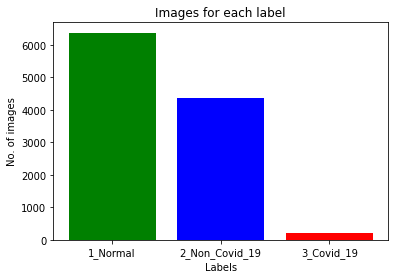

In [3]:
#display number of images in each class in training set
util.display_bar_chart(y_train)

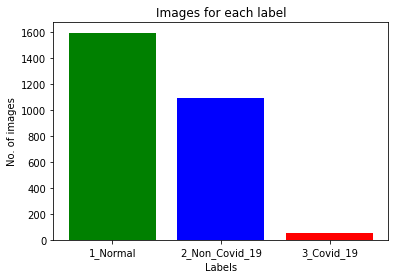

In [4]:
#display number of images in each class in test set
util.display_bar_chart(y_val)

Display Random Images


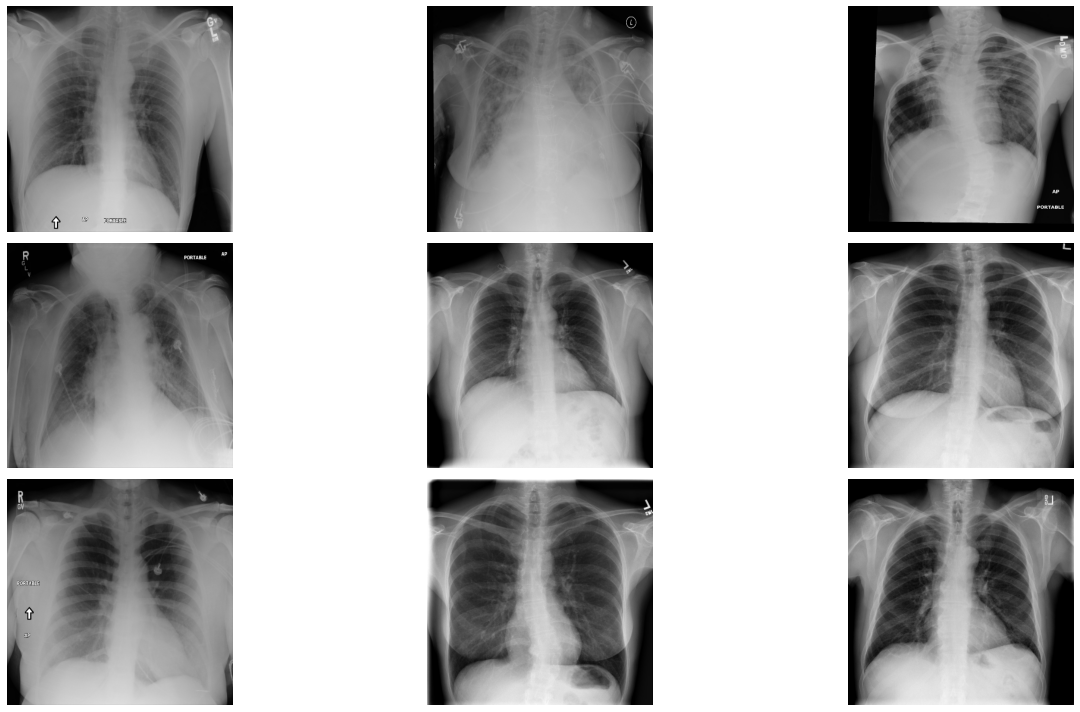

In [5]:
#display 9 random images from the training set
util.display_images(X_train)

### Generating Final Dataset for Training the Model

In [6]:
#returns the number of images in each class in the training set
normal,non_covid_19,covid_19 = util.class_counter(y_train)

#difference between non-covid and covid class claculated, from the normal class
difference_non_covid = normal-non_covid_19
difference_covid = normal - covid_19

def oversample_images(difference_non_covid,difference_covid, X_train, y_train):
    """
    This function helps in dealing with the class imbalance problem in the dataset.
    The non-covid and covid classes have significantly less images than the normal class.
    With the use of the helper function 'apply augmentation', these classes are oversampled.
    
    The function takes in the difference of images between the covid and non-covid class,
    from the normal class, and keeps on augmenting the images till all classes have similar
    number of images.
    """
    non_covid_19, covid_19, label_non_covid_19, label_covid_19 = [], [], [], []
    non_covid_counter,covid_counter = 0,0
    
    #loops through all the images in X_train
    #if the images belong to the covid or non-covid class new augmented images are created
    #loop stops when all classes have similar number of images
    for i,item in enumerate (X_train-1):
        
        if y_train[i] == 1 and non_covid_counter < difference_non_covid:
            image = apply_augmentation(item)
            non_covid_counter += 1
            
            non_covid_19.append(image)
            label_non_covid_19.append(y_train[i])
            
        for covid_counter in range (30):
            
            if y_train[i] == 2 and covid_counter < difference_covid:
                image = apply_augmentation(item)
                covid_counter += 1
            
                covid_19.append(image)
                label_covid_19.append(y_train[i])

    return np.array(non_covid_19),np.array(label_non_covid_19),np.array(covid_19),np.array(label_covid_19)

non_covid_images,non_covid_labels,covid_images,covid_labels =oversample_images(difference_non_covid,
                                                                               difference_covid,X_train,y_train) 

#newly generated augmented images and labels are appended to the original X_train
generated_labels = np.append(non_covid_labels,covid_labels)
generated_labels = np.expand_dims(generated_labels,axis=1)
generated_images = np.append(non_covid_images,covid_images,axis=0)
X_train = np.append(X_train,generated_images,axis=0)
y_train = np.append(y_train,generated_labels,axis=0)

print(f'Shape of X_train = {X_train.shape}')
print(f'Shape of y_train = {y_train.shape}')

Shape of X_train = (19132, 380, 380, 3)
Shape of y_train = (19132, 1)


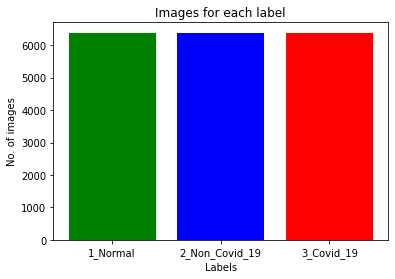

In [7]:
#number of images now similar in all classes in the training set
util.display_bar_chart(y_train)

In [8]:
def get_train_generator(X_train, y_train, shuffle=True, batch_size=8):
    """
    Return generator for training set.
    Augments the training set images - rotation, width and height shift, shearing and zoom.
    Passes the images in batches of 8.
    """        
    print("getting train generator...") 
    # augment images
    image_generator = ImageDataGenerator(rotation_range = 15,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        shear_range=0.1,
                                        zoom_range=0.1,
                                        fill_mode="nearest",
                                        cval=0.0)
    
    # flow from directory with specified batch size
    train_generator = image_generator.flow(X_train,
                                            y=y_train,
                                            shuffle=shuffle,
                                            batch_size=batch_size)
    return train_generator


def get_test_and_valid_generator(X_val, y_val, X_test, y_test, shuffle=False, batch_size=8):
    """
    Return generator for validation set and test set.
    No augmnentation is applied on the validation and test set.
    Passed in batches of 8 images.
    """
    print("getting test and valid generators...")
    # get test generator
    image_generator = ImageDataGenerator()
    
    valid_generator = image_generator.flow(X_val,
                                            y=y_val,
                                            batch_size=batch_size,
                                            shuffle=shuffle)

    test_generator = image_generator.flow(X_test,
                                            y=y_test,
                                            batch_size=batch_size,
                                            shuffle=shuffle)
    return valid_generator, test_generator

train_generator = get_train_generator(X_train,y_train)
val_generator, test_generator = get_test_and_valid_generator(X_val,y_val,X_test,y_test)

getting train generator...
getting test and valid generators...


### Defining the Model - Efficientnet B4 - Finetuning the imagenet weights

In [9]:
#declare the input image size
input_shape = [380,380]

#call the pretrained EfficienNetB4 model
#Last layer is excluded
#model to be fine tuned on the image net weights
base_model = EfficientNetB4 (input_shape = input_shape+[3], weights = 'imagenet', include_top = False)

x = base_model.output
x = GlobalAvgPool2D()(x)

#add some extra fully connected layers with dropout to prevent overfitting
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.4)(x)

#final dense layer. Dense has 3 uints for 3 class classification
outputs = Dense(3, activation="softmax")(x)

#create the model
model = Model(base_model.input, outputs, name="EfficientNet")

#visualize the model summary
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 380, 380, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

### Training the Model

In [10]:
#schedule learning rate
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

#set early stopping with focus on validation loss
stopping = EarlyStopping(monitor='val_loss', patience=6)

#save model on validation loss decrease
callbacks = ModelCheckpoint('Efficientnet_covid.h5', monitor='val_loss', save_best_only=True, mode = 'auto')

#set optimizer as Adam with learning rate of 1e-3
#use sparse categorical crossentropy loss as the labels are not one-hot encoded
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#set batch size
batch_size = 8

#Ceiling is used because we do not drop the remainder of the batch
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))

steps_per_epoch = compute_steps_per_epoch(len(X_train))
val_steps = compute_steps_per_epoch(len(X_val))

#check time to train model
start_time = time.time()

#train the model
model_history = model.fit(train_generator,
                          steps_per_epoch = steps_per_epoch,
                          epochs=100,
                          validation_data=val_generator,
                          validation_steps=val_steps
                          callbacks = [callbacks,lr_schedule,stopping])

stop_time = time.time()
print(f'Model trained in {stop_time-start_time} seconds')

Epoch 1/100
2392/2392 [==============================] - 976s 408ms/step - loss: 0.3808 - accuracy: 0.8679 - val_loss: 0.4638 - val_accuracy: 0.8665
Epoch 2/100
2392/2392 [==============================] - 958s 400ms/step - loss: 0.2553 - accuracy: 0.9175 - val_loss: 0.2215 - val_accuracy: 0.9294
Epoch 3/100
2392/2392 [==============================] - 975s 408ms/step - loss: 0.2161 - accuracy: 0.9299 - val_loss: 0.2356 - val_accuracy: 0.9291
Epoch 4/100
2392/2392 [==============================] - 986s 412ms/step - loss: 0.1917 - accuracy: 0.9381 - val_loss: 0.3264 - val_accuracy: 0.8918
Epoch 5/100
2392/2392 [==============================] - 988s 413ms/step - loss: 0.1713 - accuracy: 0.9463 - val_loss: 0.1845 - val_accuracy: 0.9404
Epoch 6/100
2392/2392 [==============================] - 984s 411ms/step - loss: 0.1535 - accuracy: 0.9510 - val_loss: 0.2350 - val_accuracy: 0.9371
Epoch 7/100
2392/2392 [==============================] - 983s 411ms/step - loss: 0.1358 - accuracy: 0.9571

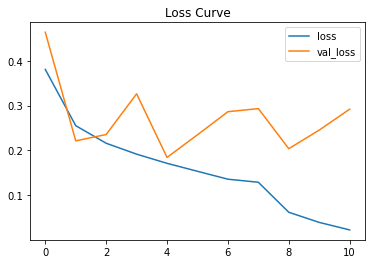

In [11]:
#plot the loss curve
plt.plot(model_history.history['loss'],label='loss')
plt.plot(model_history.history['val_loss'],label='val_loss')
plt.title('Loss Curve')
plt.legend()

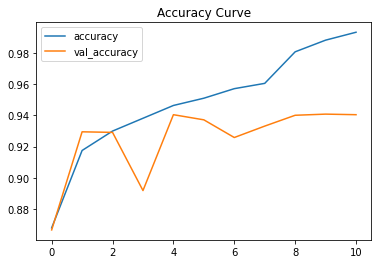

In [12]:
#plot the accuracy curve
plt.plot(model_history.history['accuracy'],label='accuracy')
plt.plot(model_history.history['val_accuracy'],label='val_accuracy')
plt.title('Accuracy Curve')
plt.legend()

### Metrics

In [9]:
#load the final saved model
final_model = tf.keras.models.load_model('Efficientnet_covid.h5')

([<matplotlib.axis.YTick at 0x22f07c67a88>,
 [Text(0, 0, '1_Normal'),
  Text(0, 1, '2_Non_Covid_19'),
  Text(0, 2, '3_Covid_19')])

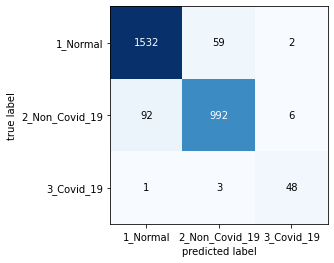

In [10]:
#Confusion matrix for Validation set
prediction_val= final_model.predict(val_generator, steps=len(val_generator)).argmax(axis=1)
matrix = confusion_matrix (y_val, prediction_val)
plot_confusion_matrix(matrix, figsize=(4,4))
plt.xticks(range(3), ['1_Normal','2_Non_Covid_19','3_Covid_19'], fontsize=10)
plt.yticks(range(3), ['1_Normal','2_Non_Covid_19', '3_Covid_19'], fontsize=10)

([<matplotlib.axis.YTick at 0x22f07d09f08>,
 [Text(0, 0, '1_Normal'),
  Text(0, 1, '2_Non_Covid_19'),
  Text(0, 2, '3_Covid_19')])

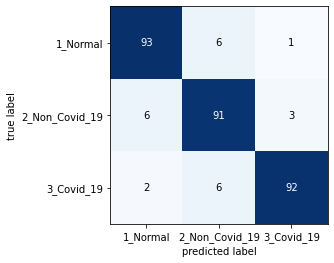

In [11]:
#Confusion Matrix for Test set
prediction_test= final_model.predict(test_generator, steps=len(test_generator)).argmax(axis=1)
matrix = confusion_matrix (y_test, prediction_test)
plot_confusion_matrix(matrix, figsize=(4,4))
plt.xticks(range(3), ['1_Normal','2_Non_Covid_19','3_Covid_19'], fontsize=10)
plt.yticks(range(3), ['1_Normal','2_Non_Covid_19', '3_Covid_19'], fontsize=10)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

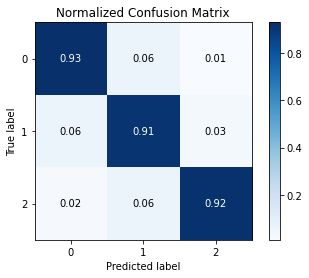

In [12]:
#Normalized Confusion Matrix for Test set
skplt.metrics.plot_confusion_matrix(y_test, prediction_test, normalize=True)

In [13]:
#Use the helper function to find the True Positive, True negative, False Positive and False Negative values
tp, fp, tn, fn = util.get_confusion_matrix_stats(y_test, prediction_test)

print('True Positive = ',tp)
print('True Negative = ',tn)
print('False Positive = ',fp)
print('False Negative = ',fn)
print()

#Use the helper functions to find the Recall, Precision and F-score of the model
#and all classes seperately
util.calculate_metrics(y_test,prediction_test,'Model')
util.calculate_metrics(y_test==0,prediction_test==0,'Class - Normal')
util.calculate_metrics(y_test==1,prediction_test==1,'Class - Non_COVID_19')
util.calculate_metrics(y_test==2,prediction_test==2,'Class - COVID_19')

True Positive =  91
True Negative =  93
False Positive =  12
False Negative =  8

Recall of Model is =  0.92
Precision of Model is =  0.88
F-Score is Model is = 0.9

Recall of Class - Normal is =  0.93
Precision of Class - Normal is =  0.92
F-Score is Class - Normal is = 0.92

Recall of Class - Non_COVID_19 is =  0.91
Precision of Class - Non_COVID_19 is =  0.88
F-Score is Class - Non_COVID_19 is = 0.89

Recall of Class - COVID_19 is =  0.92
Precision of Class - COVID_19 is =  0.96
F-Score is Class - COVID_19 is = 0.94



### Display Results

Original Label =  Normal
Predicted Label =  Normal
Accuracy of prediction in % =  99.86


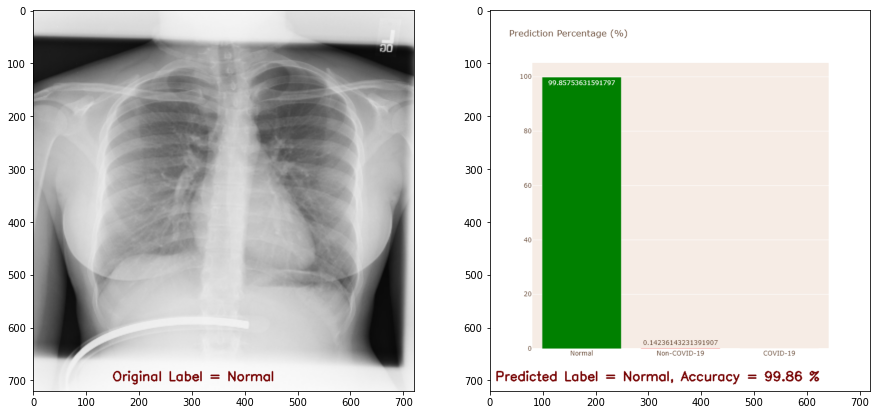

In [14]:
#use helper function to display a random image from test set
#predict the class of the test set image
#plot the class accuracies in a bar chart
#this cell loads a random image from the test set each time this is run

num = random.randint(1,len(X_test)-1)
util.show_image_and_prediction(num,final_model,X_test,y_test,image_size=380)

Original Label =  COVID-19
Predicted Label =  Normal
Accuracy of prediction in % =  44.21


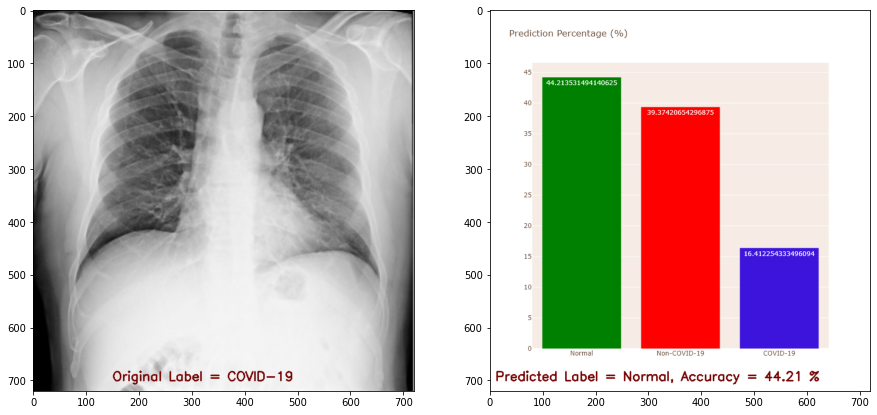

In [27]:
#use helper function to display a random image from test set
#predict the class of the test set image
#plot the class accuracies in a bar chart
#this cell loads a random image from the test set each time this is run

num = random.randint(1,len(X_test)-1)
util.show_image_and_prediction(num,final_model,X_test,y_test,image_size=380)

Original Label =  COVID-19
Predicted Label =  COVID-19
Accuracy of prediction in % =  99.97


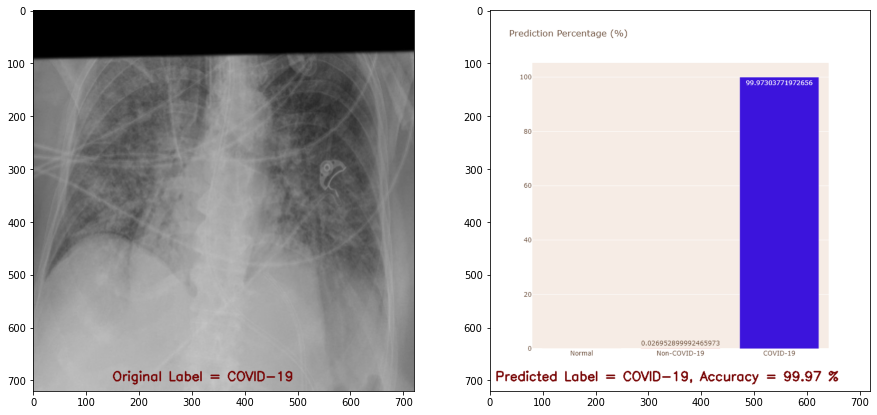

In [16]:
#use helper function to display a random image from test set
#predict the class of the test set image
#plot the class accuracies in a bar chart
#this cell loads a random image from the test set each time this is run

num = random.randint(1,len(X_test)-1)
util.show_image_and_prediction(num,final_model,X_test,y_test,image_size=380)